In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import trade_data
from passivbot import load_settings
from backtester import *

In [3]:
plt.rcParams['figure.figsize'] = [21, 13]
pd.set_option('precision', 10)

In [4]:
settings = load_settings('default')
settings

{'quot': 'BTC',
 'coins_long': ['ADA',
  'ATOM',
  'BAT',
  'BCH',
  'BNB',
  'DASH',
  'EOS',
  'ETC',
  'ETH',
  'IOST',
  'IOTA',
  'LINK',
  'LTC',
  'MATIC',
  'NEO',
  'ONT',
  'QTUM',
  'RVN',
  'TRX',
  'VET',
  'XLM',
  'XMR',
  'XRP',
  'XTZ',
  'ZEC'],
 'coins_shrt': ['ADA',
  'ATOM',
  'BAT',
  'BCH',
  'DASH',
  'EOS',
  'ETC',
  'ETH',
  'IOST',
  'IOTA',
  'LINK',
  'LTC',
  'MATIC',
  'NEO',
  'ONT',
  'QTUM',
  'RVN',
  'TRX',
  'VET',
  'XLM',
  'XMR',
  'XRP',
  'XTZ',
  'ZEC'],
 'do_not_borrow': ['BNB'],
 'profit_pct': 0.0025,
 'account_equity_pct_per_trade': 0.0002,
 'account_equity_pct_per_hour': 0.000384,
 'hours_rolling_small_trade_window': 1.0,
 'bnb_buffer': 50.3,
 'max_memory_span_days': 120,
 'snapshot_timestamp_millis': 0,
 'ema_spans_minutes': [15, 25, 40, 64, 102, 164, 263, 421, 675, 1080],
 'exponent': 15,
 'user': 'default'}

In [5]:
# ema spans
'''
p = 1.65
max_span = 60 * 36
n = 11
spans = np.array([p**i for i in range(n)])
spans = list((spans / spans.max() * max_span).round().astype(int))
spans
'''

'\np = 1.65\nmax_span = 60 * 36\nn = 11\nspans = np.array([p**i for i in range(n)])\nspans = list((spans / spans.max() * max_span).round().astype(int))\nspans\n'

In [6]:
fee = 1 - 0.0675 * 0.01 # vip1


# modify settings here

#settings['hours_rolling_small_trade_window'] = 1.0
#settings['ema_spans_minutes'] = spans
#settings['profit_pct'] = 0.0025

#settings['account_equity_pct_per_trade'] = 0.0002

#settings['account_equity_pct_per_hour'] = 0.000389

#settings['max_memory_span_days'] = 120

#settings['exponent'] = 15

#settings['ema_spans_minutes'] = [15, 25, 40, 64, 102, 164, 263, 421, 675, 1080]
print(settings['account_equity_pct_per_trade'] * 60)

0.012


In [7]:
symbols = [f'{c}/BTC' for c in settings['coins_long']]
symbols = sorted(symbols)
n_days = 30 * 13
#symbols = [s for s in symbols if not any(s.startswith(c) for c in ['VET', 'IOST'])]
symbols

['ADA/BTC',
 'ATOM/BTC',
 'BAT/BTC',
 'BCH/BTC',
 'BNB/BTC',
 'DASH/BTC',
 'EOS/BTC',
 'ETC/BTC',
 'ETH/BTC',
 'IOST/BTC',
 'IOTA/BTC',
 'LINK/BTC',
 'LTC/BTC',
 'MATIC/BTC',
 'NEO/BTC',
 'ONT/BTC',
 'QTUM/BTC',
 'RVN/BTC',
 'TRX/BTC',
 'VET/BTC',
 'XLM/BTC',
 'XMR/BTC',
 'XRP/BTC',
 'XTZ/BTC',
 'ZEC/BTC']

In [8]:
# set no_download to True to load faster if already downloaded ohlcvs
high_low_means = load_hlms(symbols, n_days, no_download=False)

fetched 1m ohlcvs for ADA/BTC 2020-07-04T22:29:00
fetched 1m ohlcvs for ADA/BTC 2020-06-27T14:50:00
fetched 1m ohlcvs for ADA/BTC 2020-04-24T13:50:00
fetched 1m ohlcvs for ADA/BTC 2020-03-03T19:50:00
fetched 1m ohlcvs for ADA/BTC 2020-02-19T01:50:00
fetched 1m ohlcvs for ADA/BTC 2020-02-08T11:20:00
fetched 1m ohlcvs for ADA/BTC 2019-11-24T12:20:00
fetched 1m ohlcvs for ADA/BTC 2019-11-12T13:53:00
fetched 1m ohlcvs for ADA/BTC 2019-08-14T19:20:00
fetched 1m ohlcvs for ADA/BTC 2019-06-07T07:35:00
2020-07-05T15:08:41  2019-06.csv already present, merging... 
2020-07-05T15:08:41  2019-08.csv already present, merging... 
2020-07-05T15:08:42  2019-11.csv already present, merging... 
2020-07-05T15:08:43  2020-02.csv already present, merging... 
2020-07-05T15:08:43  2020-03.csv already present, merging... 
2020-07-05T15:08:44  2020-04.csv already present, merging... 
2020-07-05T15:08:45  2020-06.csv already present, merging... 
2020-07-05T15:08:45  2020-07.csv already present, merging... 
fetc

fetched 1m ohlcvs for ETH/BTC 2020-06-27T14:50:00
fetched 1m ohlcvs for ETH/BTC 2020-04-24T13:50:00
fetched 1m ohlcvs for ETH/BTC 2020-03-03T19:50:00
fetched 1m ohlcvs for ETH/BTC 2020-02-19T01:50:00
fetched 1m ohlcvs for ETH/BTC 2020-02-08T11:20:00
fetched 1m ohlcvs for ETH/BTC 2019-11-24T12:20:00
fetched 1m ohlcvs for ETH/BTC 2019-11-12T13:53:00
fetched 1m ohlcvs for ETH/BTC 2019-08-14T19:20:00
fetched 1m ohlcvs for ETH/BTC 2019-06-10T04:54:00
2020-07-05T15:10:43  2019-06.csv already present, merging... 
2020-07-05T15:10:43  2019-08.csv already present, merging... 
2020-07-05T15:10:44  2019-11.csv already present, merging... 
2020-07-05T15:10:45  2020-02.csv already present, merging... 
2020-07-05T15:10:46  2020-03.csv already present, merging... 
2020-07-05T15:10:46  2020-04.csv already present, merging... 
2020-07-05T15:10:47  2020-06.csv already present, merging... 
2020-07-05T15:10:48  2020-07.csv already present, merging... 
fetched 1m ohlcvs for IOST/BTC 2020-07-04T22:31:00
fet

fetched 1m ohlcvs for QTUM/BTC 2020-02-08T11:20:00
fetched 1m ohlcvs for QTUM/BTC 2019-11-24T12:20:00
fetched 1m ohlcvs for QTUM/BTC 2019-11-12T13:53:00
fetched 1m ohlcvs for QTUM/BTC 2019-08-14T19:20:00
fetched 1m ohlcvs for QTUM/BTC 2019-06-10T14:12:00
2020-07-05T15:12:39  2019-06.csv already present, merging... 
2020-07-05T15:12:39  2019-08.csv already present, merging... 
2020-07-05T15:12:40  2019-11.csv already present, merging... 
2020-07-05T15:12:41  2020-02.csv already present, merging... 
2020-07-05T15:12:41  2020-03.csv already present, merging... 
2020-07-05T15:12:42  2020-04.csv already present, merging... 
2020-07-05T15:12:43  2020-06.csv already present, merging... 
2020-07-05T15:12:44  2020-07.csv already present, merging... 
fetched 1m ohlcvs for RVN/BTC 2020-07-04T22:33:00
fetched 1m ohlcvs for RVN/BTC 2020-06-27T14:50:00
fetched 1m ohlcvs for RVN/BTC 2020-04-24T13:50:00
fetched 1m ohlcvs for RVN/BTC 2020-03-03T19:50:00
fetched 1m ohlcvs for RVN/BTC 2020-02-19T01:50:00

fetched 1m ohlcvs for ZEC/BTC 2020-03-03T19:50:00
fetched 1m ohlcvs for ZEC/BTC 2020-02-19T01:50:00
fetched 1m ohlcvs for ZEC/BTC 2020-02-08T11:20:00
fetched 1m ohlcvs for ZEC/BTC 2019-11-24T12:20:00
fetched 1m ohlcvs for ZEC/BTC 2019-11-12T13:53:00
fetched 1m ohlcvs for ZEC/BTC 2019-08-14T19:20:00
fetched 1m ohlcvs for ZEC/BTC 2019-06-10T04:52:00
2020-07-05T15:14:45  2019-06.csv already present, merging... 
2020-07-05T15:14:45  2019-08.csv already present, merging... 
2020-07-05T15:14:46  2019-11.csv already present, merging... 
2020-07-05T15:14:47  2020-02.csv already present, merging... 
2020-07-05T15:14:48  2020-03.csv already present, merging... 
2020-07-05T15:14:48  2020-04.csv already present, merging... 
2020-07-05T15:14:49  2020-06.csv already present, merging... 
2020-07-05T15:14:50  2020-07.csv already present, merging... 


In [9]:
df = add_emas(high_low_means, settings['ema_spans_minutes'])
print(f'n_days {(df.index[-1] - df.index[0]) / 1000 / 60 / 60 / 24:2f}')

n_days 390.003472


In [10]:
balance_list, lentr, sentr, lexit, sexit, lexitpl, sexitpl = backtest(df, settings)

100.00% acc equity quot: 1.021294  avg daily gain: 1.000054 

In [11]:
# balances are in terms of quot
bldf = pd.DataFrame(balance_list).set_index('timestamp')

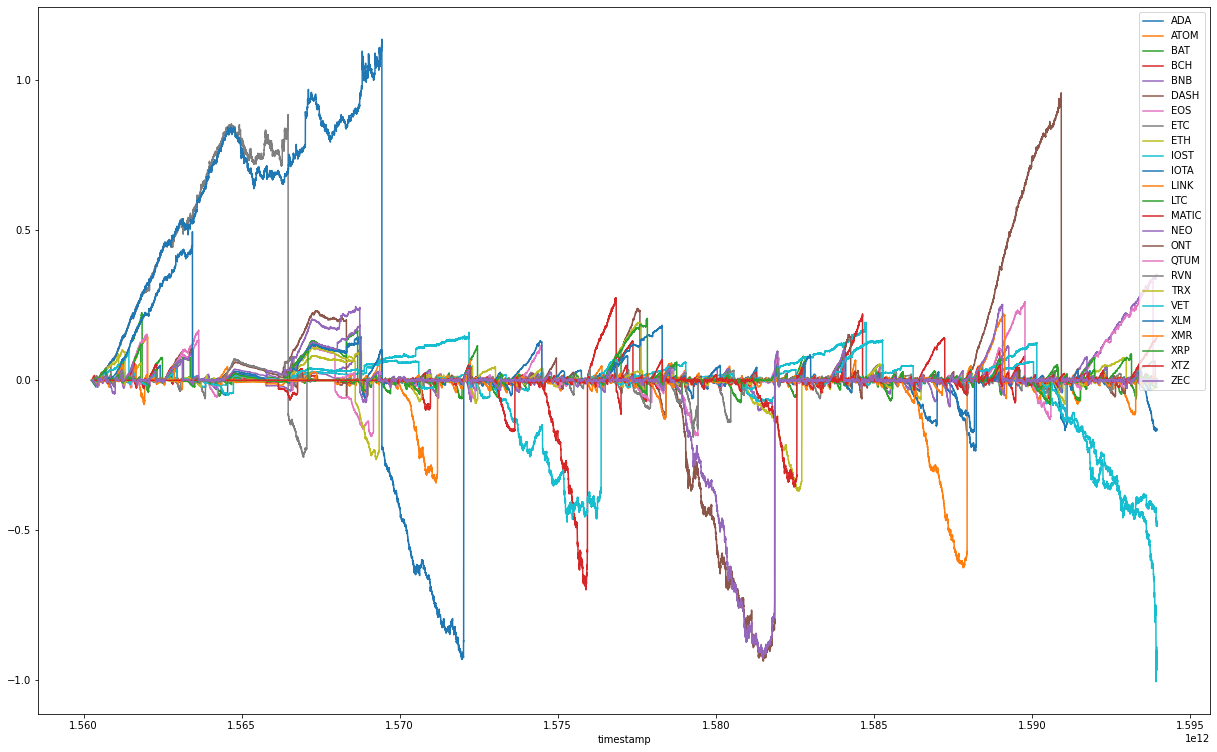

In [12]:
bldf.drop(['acc_equity_quot', 'acc_debt_quot', 'BTC'], axis=1).iloc[::10].plot()

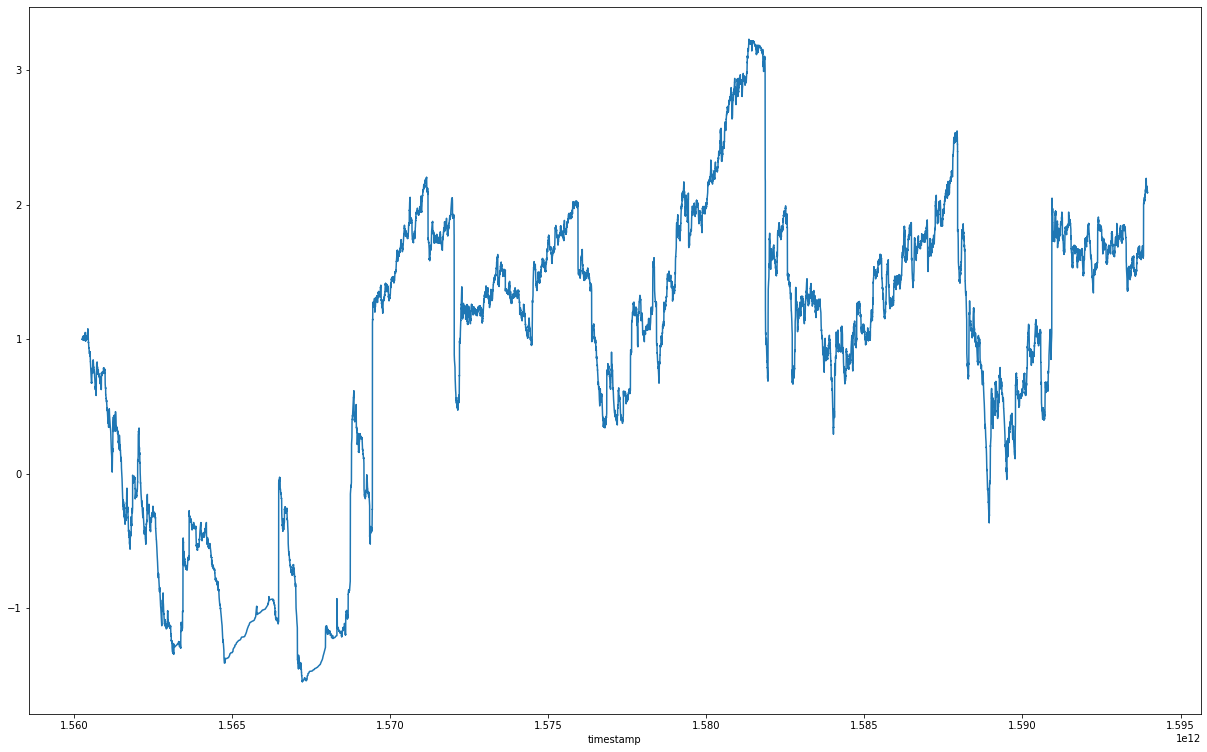

In [13]:
bldf.BTC.iloc[::10].plot()

start end daily gain 1.00005403
      max daily gain 1.001072688338051
      low water mark 0.339915490004995
     high water mark 1.4700846848054139
                 end 1.0212940021866597
                mean 1.1141449832488188


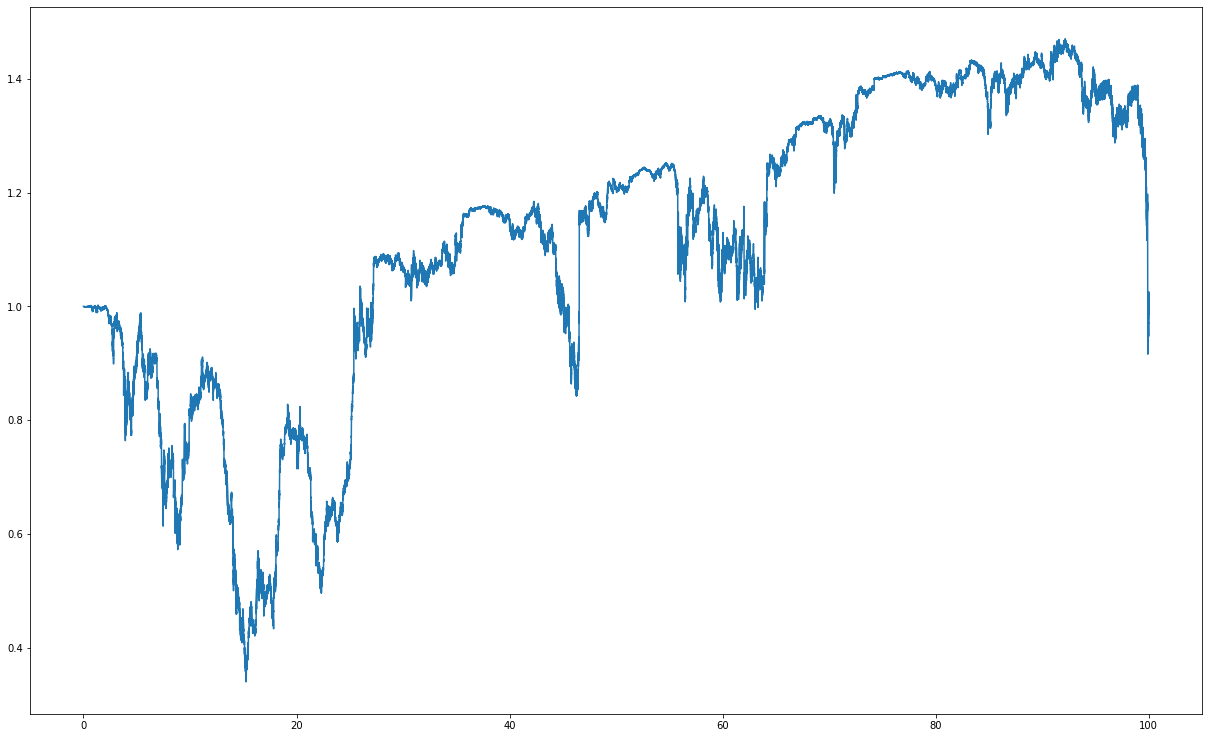

In [14]:
start_equity = bldf.acc_equity_quot.iloc[0]
end_equity = bldf.acc_equity_quot.iloc[-1]
n_days = (bldf.index[-1] - bldf.index[0]) / 1000 / 60 / 60 / 24
avg_daily_gain = (end_equity / start_equity)**(1 / n_days)
hwme = bldf.acc_equity_quot.max()
hwmi = bldf.acc_equity_quot.idxmax()
n_days_hwm = (hwmi - bldf.index[0]) / 1000 / 60 / 60 / 24
ideal_daily_gain = (hwme / start_equity)**(1 / n_days_hwm)
print('start end daily gain', round(avg_daily_gain, 8))
print('      max daily gain', ideal_daily_gain)
print('      low water mark', bldf.acc_equity_quot.min())
print('     high water mark', hwme)
print('                 end', bldf.acc_equity_quot.iloc[-1])
print('                mean', bldf.acc_equity_quot.mean())

plt.plot(np.linspace(0, 100, len(bldf)), bldf.acc_equity_quot.values)


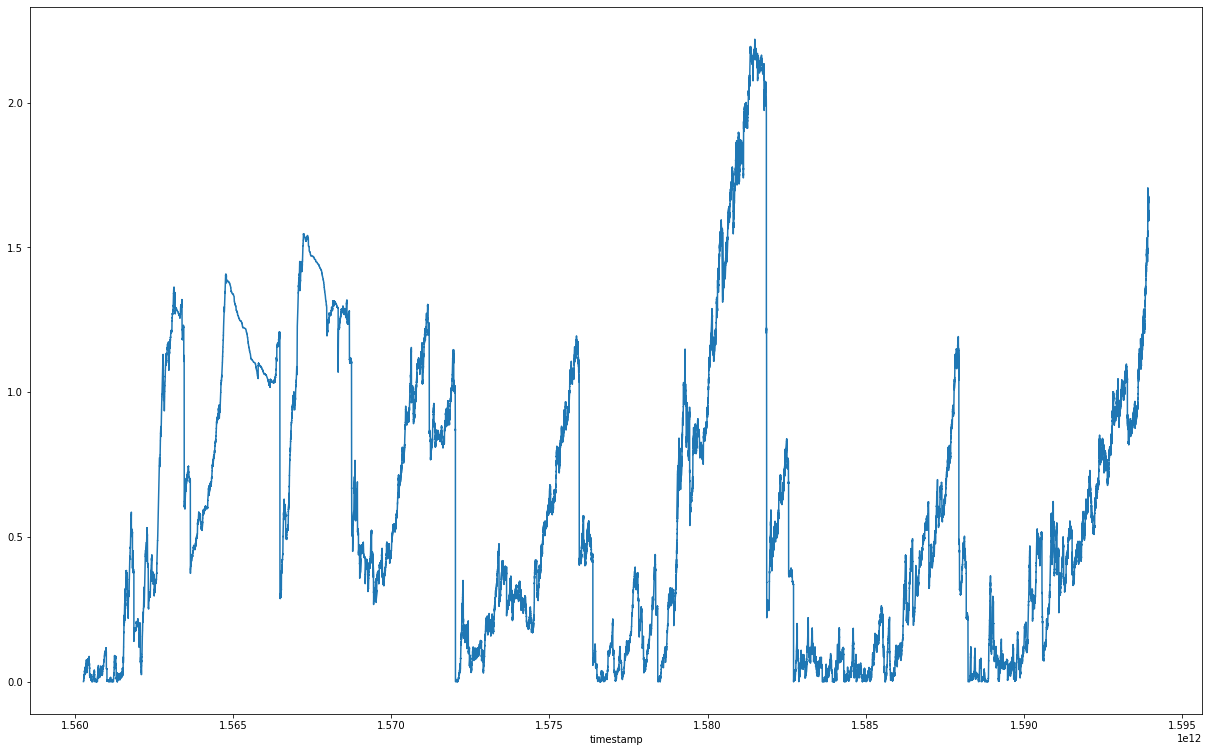

In [15]:
bldf.acc_debt_quot.plot()

In [16]:
# bag status at end
sorted([(round(e[1], 6), e[0]) for e in dict(bldf.iloc[-1]).items() if 'acc' not in e[0]])

[(-0.890751, 'VET'),
 (-0.483504, 'IOST'),
 (-0.164014, 'ADA'),
 (-0.023504, 'EOS'),
 (-0.021899, 'TRX'),
 (-0.00584, 'ATOM'),
 (-0.002235, 'LTC'),
 (-0.00177, 'ONT'),
 (-0.001631, 'ZEC'),
 (-0.00085, 'DASH'),
 (-0.00082, 'XRP'),
 (9.1e-05, 'XMR'),
 (0.000811, 'RVN'),
 (0.001566, 'BAT'),
 (0.001718, 'ETH'),
 (0.002221, 'QTUM'),
 (0.002477, 'MATIC'),
 (0.002575, 'IOTA'),
 (0.002873, 'XLM'),
 (0.002942, 'NEO'),
 (0.003469, 'ETC'),
 (0.004126, 'BCH'),
 (0.005324, 'LINK'),
 (0.142987, 'XTZ'),
 (0.35328, 'BNB'),
 (2.091654, 'BTC')]

In [17]:
r = {}
for s in map(lambda x: x.replace('/', '_'), symbols):
    # all buys
    abdf = pd.DataFrame(sorted(lentr[s] + sexit[s], key=lambda x: x['timestamp'])).set_index('timestamp')

    # all sels
    asdf = pd.DataFrame(sorted(sentr[s] + lexit[s], key=lambda x: x['timestamp'])).set_index('timestamp')
    buy_cost = (abdf.price * abdf.amount).sum()
    sel_cost = (asdf.price * asdf.amount).sum()
    sum_cost = buy_cost + sel_cost
    buy_vwap = buy_cost / abdf.amount.sum()
    sel_vwap = sel_cost / asdf.amount.sum()
    diff = (sel_vwap / buy_vwap) * fee**2
    approx_profit = buy_cost * (diff * fee**2 - 1)
    r[s] = {'vol': sum_cost, 'svwap / bvwap': sel_vwap / buy_vwap,
            'vol * (sel_vwap / buy_vwap * fee**2 - 1)': sum_cost * (sel_vwap / buy_vwap * fee**2 - 1)}

sum_vol = sum(r[s]['vol'] for s in r)
print('sum vol', sum_vol)
print('monthly vol', sum_vol / n_days * 30)
rdf = pd.DataFrame(r).T.sort_values('vol * (sel_vwap / buy_vwap * fee**2 - 1)')
print('sum', rdf['vol * (sel_vwap / buy_vwap * fee**2 - 1)'].sum())
rdf

sum vol 270.38285703580317
monthly vol 20.79849613865029
sum 1.3710502922037675


,vol,svwap / bvwap,vol * (sel_vwap / buy_vwap * fee**2 - 1)
IOST_BTC,4.0254566232,0.9839700535,-0.0698733033
XTZ_BTC,10.9940949670,1.0003809680,-0.0106542734
EOS_BTC,12.1594547665,1.0026278656,0.0155005666
BCH_BTC,7.8898923531,1.0043156185,0.0233560542
ETH_BTC,11.7882434505,1.0034184013,0.0243338068
LTC_BTC,11.5814038721,1.0036870808,0.0270143255
XRP_BTC,10.8966902674,1.0039505163,0.0282838909
TRX_BTC,5.9184893784,1.0066829819,0.0315125144
XMR_BTC,11.7932272650,1.0043066765,0.0348055889
NEO_BTC,11.7918898805,1.0043773898,0.0356343591


In [18]:
# analyze particular symbol
s = 'VET_BTC'

In [19]:
ledf = pd.DataFrame(lentr[s]).set_index('timestamp')
sedf = pd.DataFrame(sentr[s]).set_index('timestamp')
lexitdf = pd.DataFrame(lexit[s]).set_index('timestamp')
sexitdf = pd.DataFrame(sexit[s]).set_index('timestamp')
lexitpdf = pd.DataFrame(lexitpl[s]).set_index('timestamp')
sexitpdf = pd.DataFrame(sexitpl[s]).set_index('timestamp')

In [20]:
# longest bag durations
d = 1000 * 60 * 60 * 24
for e in sorted(np.diff(np.append(lexitdf.index, ledf.index[-1]) / d))[-10:]:
    print('long bag duration days', round(e, 2))
print()
for e in sorted(np.diff(np.append(sexitdf.index, sedf.index[-1]) / d))[-10:]:
    print('shrt bag duration days', round(e, 2))

long bag duration days 5.01
long bag duration days 5.4
long bag duration days 8.48
long bag duration days 12.57
long bag duration days 12.82
long bag duration days 12.89
long bag duration days 16.21
long bag duration days 23.57
long bag duration days 25.96
long bag duration days 75.66

shrt bag duration days 8.51
shrt bag duration days 8.91
shrt bag duration days 9.41
shrt bag duration days 9.65
shrt bag duration days 12.62
shrt bag duration days 16.68
shrt bag duration days 23.77
shrt bag duration days 26.71
shrt bag duration days 43.86
shrt bag duration days 47.6


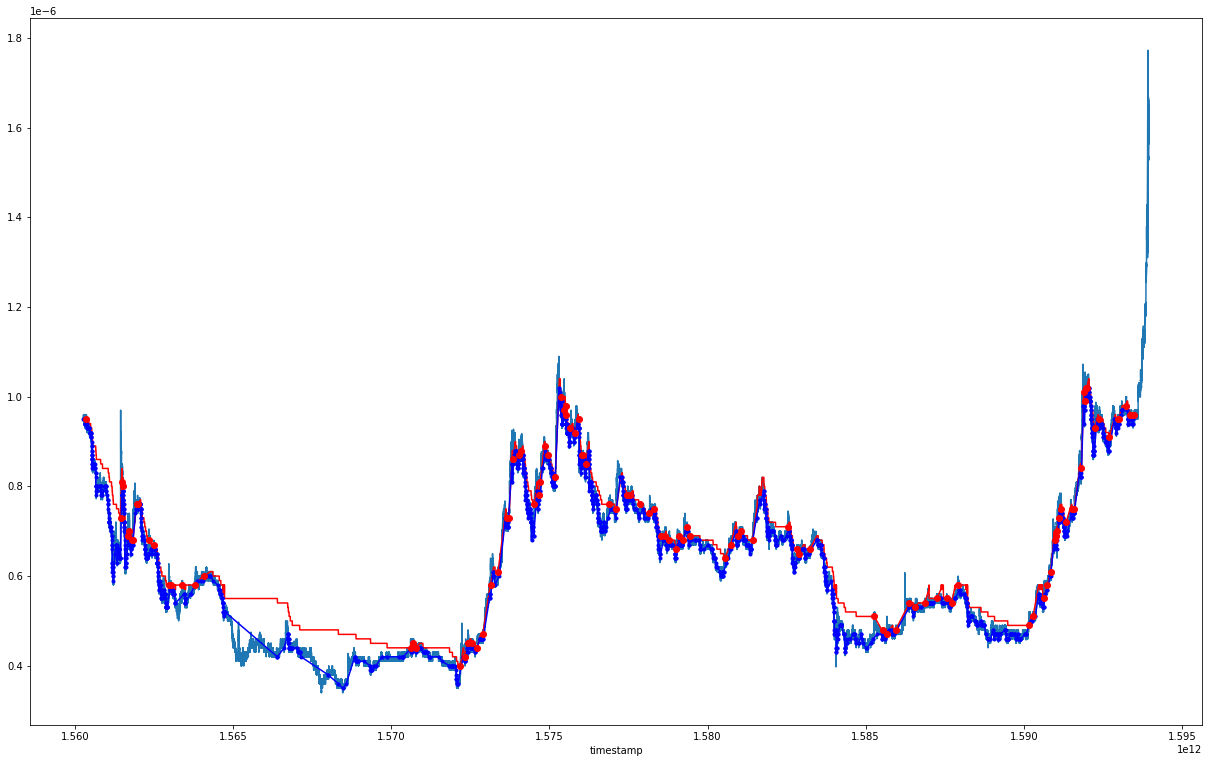

In [21]:
high_low_means[s + '_mean'].plot()
lexitpdf.price.plot(style='r-')
ledf.price.plot(style='b.-')
lexitdf.price.plot(style='ro')

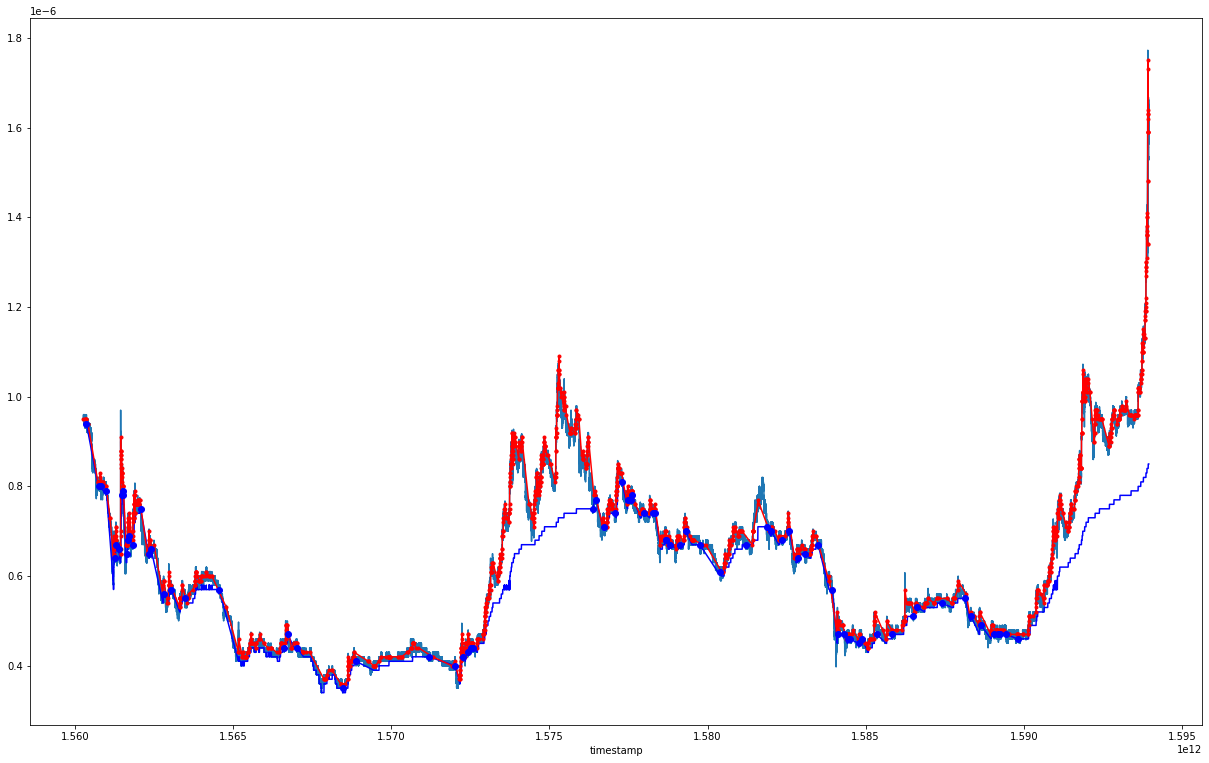

In [22]:
high_low_means[s + '_mean'].plot()
sexitpdf.price.plot(style='b-')
sedf.price.plot(style='r.-')
sexitdf.price.plot(style='bo')